### Setup

In [122]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
import os
keras = tf.keras

In [2]:
def plot_series(time, series, format = "-", start = 0, end = None, label = None):
    plt.plot(time[start:end], series[start:end], format, label = label)
    plt.xlabel("Time")
    plt.ylabel("Series")
    if label:
        plt.legend(fontsize = 14)
    plt.grid()
    
def trend(time, slope = 0):
    return time * slope

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                   np.cos(season_time * 2 * np.pi),
                   1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude = 1, phase = 0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def white_noise(time, noise_level = 1, seed = None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

### Trend and seasonality

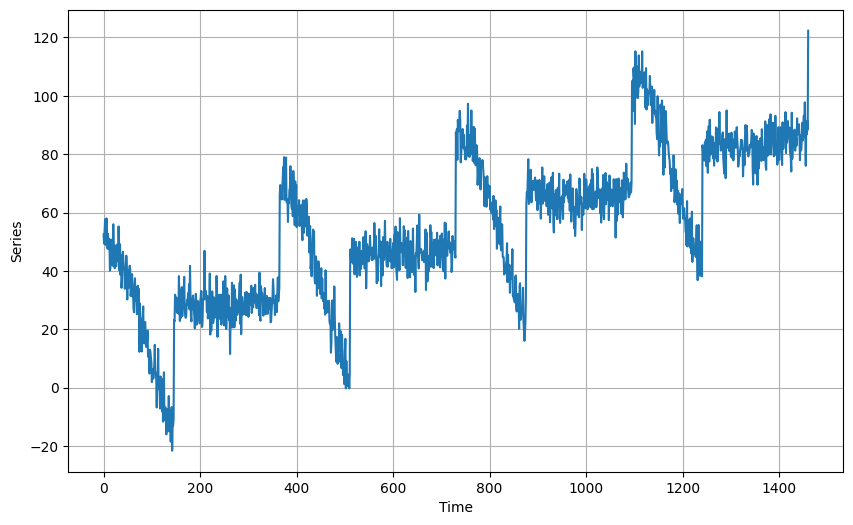

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40

series = baseline + trend(time, slope) + seasonality(time, period = 365, amplitude = amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed = 42)

series += noise

plt.figure(figsize = (10, 6))
plot_series(time, series)
plt.show()

#### Split dataset

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

### Simple RNN Training

#### Prepare data

In [50]:
def window_dataset(series, window_size, batch_size = 32,
                  shuffle_buffer = 1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

def model_forecast(model, series, window_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift = 1, drop_remainder = True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size))
    dataset = dataset.batch(32).prefetch(1)
    forecast = model.predict(dataset)
    return forecast

#### Build RNN model

#### Finding the best learning rate

In [12]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size = 128)

model = keras.models.Sequential([
    keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1),
                       input_shape = [None]),
    keras.layers.SimpleRNN(100, return_sequences = True),
    keras.layers.SimpleRNN(100),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epochs: 1e-7 * 10 ** (epochs / 20))

optimizer = keras.optimizers.SGD(learning_rate = 1e-7, momentum = .9)

model.compile(loss = keras.losses.Huber(),
             optimizer = optimizer,
             metrics = ['mae'])

history = model.fit(train_set, epochs = 100, callbacks = [lr_schedule])

Epoch 1/100
8/8 [==============================] - 4s 63ms/step - loss: 48.2658 - mae: 48.7653 - lr: 1.0000e-07
Epoch 2/100
8/8 [==============================] - 0s 34ms/step - loss: 20.6764 - mae: 21.1713 - lr: 1.1220e-07
Epoch 3/100
8/8 [==============================] - 0s 35ms/step - loss: 16.1444 - mae: 16.6378 - lr: 1.2589e-07
Epoch 4/100
8/8 [==============================] - 0s 35ms/step - loss: 13.6190 - mae: 14.1065 - lr: 1.4125e-07
Epoch 5/100
8/8 [==============================] - 0s 34ms/step - loss: 11.7459 - mae: 12.2318 - lr: 1.5849e-07
Epoch 6/100
8/8 [==============================] - 0s 37ms/step - loss: 11.2527 - mae: 11.7373 - lr: 1.7783e-07
Epoch 7/100
8/8 [==============================] - 0s 39ms/step - loss: 10.5809 - mae: 11.0622 - lr: 1.9953e-07
Epoch 8/100
8/8 [==============================] - 0s 35ms/step - loss: 10.5939 - mae: 11.0750 - lr: 2.2387e-07
Epoch 9/100
8/8 [==============================] - 0s 33ms/step - loss: 10.3918 - mae: 10.8715 - lr: 2.5

Plot learning_rate to loss

(1e-07, 0.0001, 0.0, 50.0)

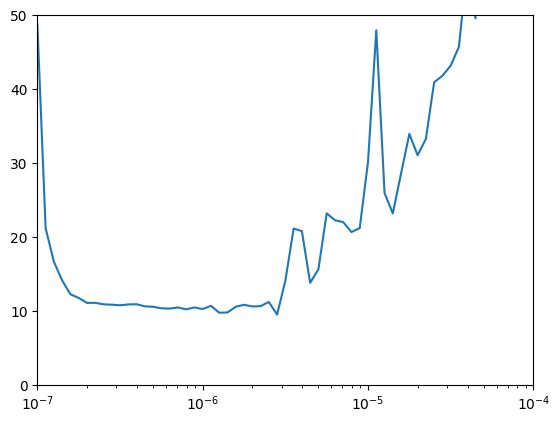

In [21]:
plt.semilogx(history.history['lr'], history.history['mae']);
plt.axis([1e-7, 1e-4, 0, 50])

#### BUild a RNN model

In [35]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size = 2)
valid_set = window_dataset(x_valid, window_size, batch_size = 1)

for x, y in train_set:
    print("x = ", x)
    print("y = ", y)
    print(tf.expand_dims(x, axis = -1))
    break

x =  tf.Tensor(
[[ 29.73035225  23.36855413  28.54108243  28.04865127  22.0284378
   29.51843418  30.52015026  33.11873199  32.96024784  20.79116199
   22.97916016  30.23273938  30.21626751  30.21284388  46.89201954
   30.4740562   33.28915439  32.37353457  30.85315469  26.01299416
   31.37779383  23.71289061  26.38745043  25.13970658  27.97132623
   39.13112625  18.21782835  30.98221556  19.48453133  25.18607967]
 [  2.91552937 -11.6490078   -2.24061686   5.2485598  -11.1787106
   -9.57315331  -6.75220097 -10.26962106 -16.00017329  -8.39132157
  -14.5254431   -7.31810123 -14.74751947  -2.85710484 -14.97131549
  -13.10537471  -7.8590999  -18.50408445 -11.62685792  -6.63401879
  -21.60376894 -13.03071659 -13.03278826 -10.79206056  23.16301492
   22.69686849  31.86104968  30.68925615  30.41058202  30.84493138]], shape=(2, 30), dtype=float64)
y =  tf.Tensor([32.98854898 25.6679204 ], shape=(2,), dtype=float64)
tf.Tensor(
[[[ 29.73035225]
  [ 23.36855413]
  [ 28.54108243]
  [ 28.04865127]


In [63]:
if "saved_models" not in os.listdir():
    os.mkdir("saved_models")
    
saved_models_path = os.path.join(os.getcwd() + '/saved_models')
checkpoint_path = saved_models_path + "/rnn_checkpoint.h5"
print(checkpoint_path)

/home/login/Documents/Machine_learning/Time_series_forecasting/saved_models/rnn_checkpoint.h5


In [46]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size = 128)
valid_set = window_dataset(x_valid, window_size, batch_size = 128)

model = keras.models.Sequential([
    keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1)),
    keras.layers.SimpleRNN(100, return_sequences = True),
    keras.layers.SimpleRNN(100),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0)
])

model.compile(loss = keras.losses.Huber(),
             optimizer = keras.optimizers.SGD(learning_rate = 1e-6, momentum = .9),
             metrics = ['mae'])

early_stopping = keras.callbacks.EarlyStopping(patience = 50)

model_checkpoint = keras.callbacks.ModelCheckpoint(
    checkpoint_path, save_best_only = True)

model.fit(train_set, epochs = 500,
         validation_data = valid_set,
         callbacks = [early_stopping, model_checkpoint])

Epoch 1/500
      7/Unknown - 3s 33ms/step - loss: 199.8651 - mae: 200.3646

/home/login/.myenv/.myenv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 4s 222ms/step - loss: 190.8592 - mae: 191.3588 - val_loss: 95.5880 - val_mae: 96.0880
Epoch 2/500
8/8 [==============================] - 1s 55ms/step - loss: 71.3967 - mae: 71.8945 - val_loss: 75.1386 - val_mae: 75.6386
Epoch 3/500
8/8 [==============================] - 1s 51ms/step - loss: 37.3063 - mae: 37.8041 - val_loss: 10.5140 - val_mae: 11.0003
Epoch 4/500
8/8 [==============================] - 0s 46ms/step - loss: 22.4232 - mae: 22.9181 - val_loss: 13.3832 - val_mae: 13.8786
Epoch 5/500
8/8 [==============================] - 1s 56ms/step - loss: 19.1761 - mae: 19.6715 - val_loss: 25.6691 - val_mae: 26.1678
Epoch 6/500
8/8 [==============================] - 0s 50ms/step - loss: 15.5249 - mae: 16.0166 - val_loss: 26.2186 - val_mae: 26.7154
Epoch 7/500
8/8 [==============================] - 0s 48ms/step - loss: 13.0733 - mae: 13.5618 - val_loss: 21.3952 - val_mae: 21.8939
Epoch 8/500
8/8 [==============================] - 0s 45ms/step - loss:

8/8 [==============================] - 1s 58ms/step - loss: 4.9081 - mae: 5.3875 - val_loss: 5.3840 - val_mae: 5.8623
Epoch 126/500
8/8 [==============================] - 0s 47ms/step - loss: 4.9190 - mae: 5.3964 - val_loss: 6.1533 - val_mae: 6.6379
Epoch 127/500
8/8 [==============================] - 1s 53ms/step - loss: 4.8167 - mae: 5.2876 - val_loss: 5.2566 - val_mae: 5.7361
Epoch 128/500
8/8 [==============================] - 0s 47ms/step - loss: 4.8800 - mae: 5.3553 - val_loss: 5.5453 - val_mae: 6.0232
Epoch 129/500
8/8 [==============================] - 0s 49ms/step - loss: 4.8790 - mae: 5.3550 - val_loss: 6.6666 - val_mae: 7.1491
Epoch 130/500
8/8 [==============================] - 1s 52ms/step - loss: 4.9795 - mae: 5.4536 - val_loss: 5.1451 - val_mae: 5.6278
Epoch 131/500
8/8 [==============================] - 0s 47ms/step - loss: 5.7869 - mae: 6.2667 - val_loss: 5.7475 - val_mae: 6.2252
Epoch 132/500
8/8 [==============================] - 0s 50ms/step - loss: 4.9864 - mae: 5.

8/8 [==============================] - 0s 48ms/step - loss: 4.7952 - mae: 5.2694 - val_loss: 5.0497 - val_mae: 5.5302
Epoch 250/500
8/8 [==============================] - 0s 48ms/step - loss: 4.4669 - mae: 4.9407 - val_loss: 5.4381 - val_mae: 5.9182
Epoch 251/500
8/8 [==============================] - 0s 44ms/step - loss: 4.5530 - mae: 5.0251 - val_loss: 5.3170 - val_mae: 5.7954
Epoch 252/500
8/8 [==============================] - 0s 44ms/step - loss: 4.6989 - mae: 5.1718 - val_loss: 5.2181 - val_mae: 5.6978
Epoch 253/500
8/8 [==============================] - 0s 48ms/step - loss: 4.4188 - mae: 4.8920 - val_loss: 5.5864 - val_mae: 6.0617
Epoch 254/500
8/8 [==============================] - 0s 42ms/step - loss: 4.3507 - mae: 4.8180 - val_loss: 5.0427 - val_mae: 5.5203
Epoch 255/500
8/8 [==============================] - 0s 46ms/step - loss: 4.7057 - mae: 5.1795 - val_loss: 7.5256 - val_mae: 8.0130
Epoch 256/500
8/8 [==============================] - 0s 43ms/step - loss: 5.0206 - mae: 5.

In [47]:
model = keras.models.load_model(checkpoint_path)

In [51]:
rnn_forecast = model_forecast(model,
            series[split_time - window_size: -1],
            window_size)[:, 0]

15/15 [==============================] - 1s 11ms/step


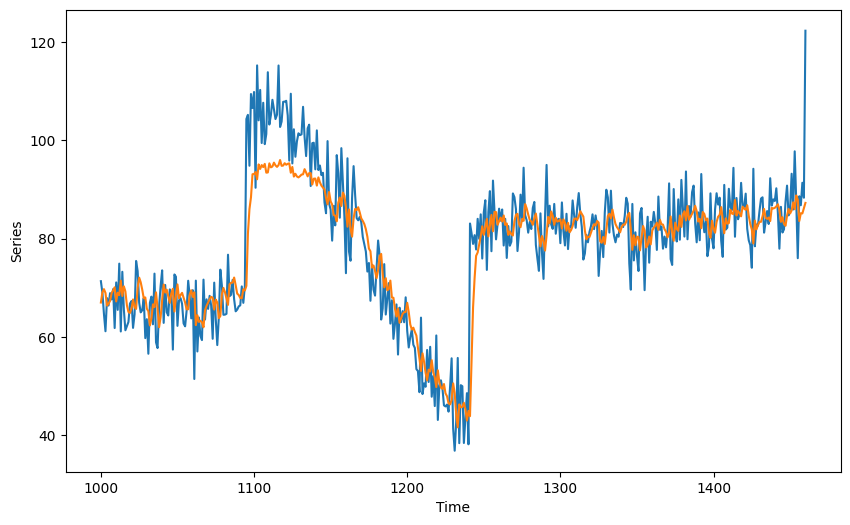

In [60]:
plt.figure(figsize = (10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [62]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.3259754

### Sequence_to_Sequence Forecasting

#### Prepare data to be used in seq2seq forecasting

In [67]:
def seq2seq_window_dataset(series, window_size, batch_size = 32,
                          shuffle_buffer = 1000):
    series = tf.expand_dims(series, axis = -1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift = 1, drop_remainder = True)
    ds = ds.flat_map(lambda window: window.batch(batch_size))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(batch_size).prefetch(1)

In [74]:
for x_batch, y_batch in seq2seq_window_dataset(tf.range(10), 3,
                                              batch_size = 3):
    print("X = ", x_batch.numpy())
    print("Y = ", y_batch.numpy())

X =  [[[3]
  [4]]

 [[6]
  [7]]

 [[4]
  [5]]]
Y =  [[[4]
  [5]]

 [[7]
  [8]]

 [[5]
  [6]]]
X =  [[[7]
  [8]]

 [[0]
  [1]]

 [[5]
  [6]]]
Y =  [[[8]
  [9]]

 [[1]
  [2]]

 [[6]
  [7]]]
X =  [[[2]
  [3]]

 [[1]
  [2]]]
Y =  [[[3]
  [4]]

 [[2]
  [3]]]


#### Build model


#### Finding the best learning for adam optimizer

In [109]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size, 
                                  batch_size = 128)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(100, return_sequences = True,
                          input_shape = [None, 1]),
    keras.layers.SimpleRNN(100, return_sequences = True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10 ** (epoch / 30))

optimizer = keras.optimizers.Adam(learning_rate = 1e-7)

model.compile(loss = keras.losses.Huber(),
             optimizer = optimizer,
             metrics = ['mae'])

history = model.fit(train_set, epochs = 100, callbacks = [lr_schedule])

Epoch 1/100
8/8 [==============================] - 2s 32ms/step - loss: 94.7098 - mae: 95.2095 - lr: 1.0000e-05
Epoch 2/100
8/8 [==============================] - 0s 29ms/step - loss: 71.5334 - mae: 72.0332 - lr: 1.0798e-05
Epoch 3/100
8/8 [==============================] - 0s 34ms/step - loss: 46.8234 - mae: 47.3223 - lr: 1.1659e-05
Epoch 4/100
8/8 [==============================] - 0s 36ms/step - loss: 26.7943 - mae: 27.2899 - lr: 1.2589e-05
Epoch 5/100
8/8 [==============================] - 0s 36ms/step - loss: 23.6194 - mae: 24.1136 - lr: 1.3594e-05
Epoch 6/100
8/8 [==============================] - 0s 33ms/step - loss: 22.1490 - mae: 22.6429 - lr: 1.4678e-05
Epoch 7/100
8/8 [==============================] - 0s 30ms/step - loss: 17.8116 - mae: 18.3039 - lr: 1.5849e-05
Epoch 8/100
8/8 [==============================] - 0s 30ms/step - loss: 16.1140 - mae: 16.6047 - lr: 1.7113e-05
Epoch 9/100
8/8 [==============================] - 0s 29ms/step - loss: 14.0801 - mae: 14.5683 - lr: 1.8

8/8 [==============================] - 0s 29ms/step - loss: 22.8819 - mae: 23.3809 - lr: 0.0029
Epoch 76/100
8/8 [==============================] - 0s 35ms/step - loss: 17.3473 - mae: 17.8447 - lr: 0.0032
Epoch 77/100
8/8 [==============================] - 0s 28ms/step - loss: 16.1871 - mae: 16.6847 - lr: 0.0034
Epoch 78/100
8/8 [==============================] - 0s 28ms/step - loss: 14.7410 - mae: 15.2369 - lr: 0.0037
Epoch 79/100
8/8 [==============================] - 0s 28ms/step - loss: 14.6162 - mae: 15.1125 - lr: 0.0040
Epoch 80/100
8/8 [==============================] - 0s 30ms/step - loss: 13.7575 - mae: 14.2538 - lr: 0.0043
Epoch 81/100
8/8 [==============================] - 0s 28ms/step - loss: 13.8879 - mae: 14.3843 - lr: 0.0046
Epoch 82/100
8/8 [==============================] - 0s 35ms/step - loss: 13.7703 - mae: 14.2658 - lr: 0.0050
Epoch 83/100
8/8 [==============================] - 0s 27ms/step - loss: 12.4280 - mae: 12.9229 - lr: 0.0054
Epoch 84/100
8/8 [==============

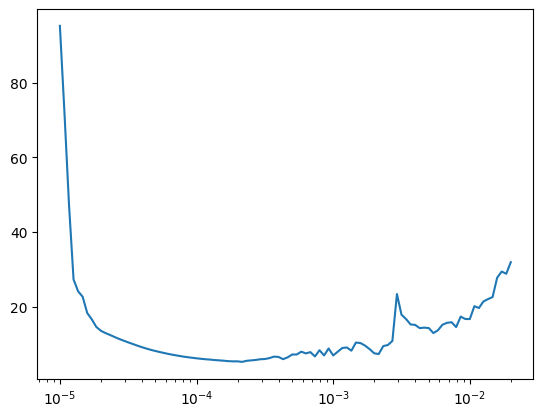

In [110]:
plt.semilogx(history.history['lr'], history.history['mae']);
# plt.axis([1e-7, 1e-4, 0, 30]);

In [111]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size, batch_size = 128)
valid_set = seq2seq_window_dataset(x_valid, window_size, batch_size = 128)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(100, return_sequences = True,
                          input_shape = [None, 1]),
    keras.layers.SimpleRNN(100, return_sequences = True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0)
])

model.compile(loss = keras.losses.Huber(),
             optimizer = keras.optimizers.Adam(learning_rate = 1e-4),
             metrics = ['mae'])

early_stopping = keras.callbacks.EarlyStopping(patience = 10)

model.fit(train_set, epochs = 500,
         validation_data = valid_set,
         callbacks = [early_stopping])

Epoch 1/500
8/8 [==============================] - 3s 95ms/step - loss: 184.8392 - mae: 185.3391 - val_loss: 46.4789 - val_mae: 46.9784
Epoch 2/500
8/8 [==============================] - 0s 42ms/step - loss: 68.0129 - mae: 68.5117 - val_loss: 41.2850 - val_mae: 41.7848
Epoch 3/500
8/8 [==============================] - 0s 42ms/step - loss: 44.8821 - mae: 45.3793 - val_loss: 51.2223 - val_mae: 51.7220
Epoch 4/500
8/8 [==============================] - 0s 44ms/step - loss: 33.2071 - mae: 33.7033 - val_loss: 25.4709 - val_mae: 25.9694
Epoch 5/500
8/8 [==============================] - 0s 41ms/step - loss: 24.4200 - mae: 24.9145 - val_loss: 17.1641 - val_mae: 17.6514
Epoch 6/500
8/8 [==============================] - 0s 41ms/step - loss: 18.7107 - mae: 19.2017 - val_loss: 13.9621 - val_mae: 14.4473
Epoch 7/500
8/8 [==============================] - 0s 42ms/step - loss: 15.0642 - mae: 15.5522 - val_loss: 12.7824 - val_mae: 13.2675
Epoch 8/500
8/8 [==============================] - 0s 42ms/s

8/8 [==============================] - 0s 52ms/step - loss: 4.0745 - mae: 4.5454 - val_loss: 4.8837 - val_mae: 5.3606
Epoch 126/500
8/8 [==============================] - 0s 44ms/step - loss: 4.0848 - mae: 4.5563 - val_loss: 4.8747 - val_mae: 5.3520
Epoch 127/500
8/8 [==============================] - 0s 45ms/step - loss: 4.0771 - mae: 4.5483 - val_loss: 4.9599 - val_mae: 5.4373
Epoch 128/500
8/8 [==============================] - 0s 48ms/step - loss: 4.1368 - mae: 4.6097 - val_loss: 4.9478 - val_mae: 5.4247
Epoch 129/500
8/8 [==============================] - 0s 47ms/step - loss: 4.1440 - mae: 4.6163 - val_loss: 4.8758 - val_mae: 5.3532
Epoch 130/500
8/8 [==============================] - 0s 45ms/step - loss: 4.0653 - mae: 4.5354 - val_loss: 4.8807 - val_mae: 5.3575
Epoch 131/500
8/8 [==============================] - 0s 50ms/step - loss: 4.0586 - mae: 4.5284 - val_loss: 4.9046 - val_mae: 5.3819
Epoch 132/500
8/8 [==============================] - 1s 53ms/step - loss: 4.0841 - mae: 4.

In [112]:
print(series[..., np.newaxis], series[..., np.newaxis].shape)
print(series, series.shape)

[[ 52.48357077]
 [ 49.35275206]
 [ 53.31473872]
 ...
 [ 91.37325376]
 [ 88.32382529]
 [122.30772008]] (1461, 1)
[ 52.48357077  49.35275206  53.31473872 ...  91.37325376  88.32382529
 122.30772008] (1461,)


In [113]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
# print(rnn_forecast[-1, 0])
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

45/45 [==============================] - 1s 8ms/step


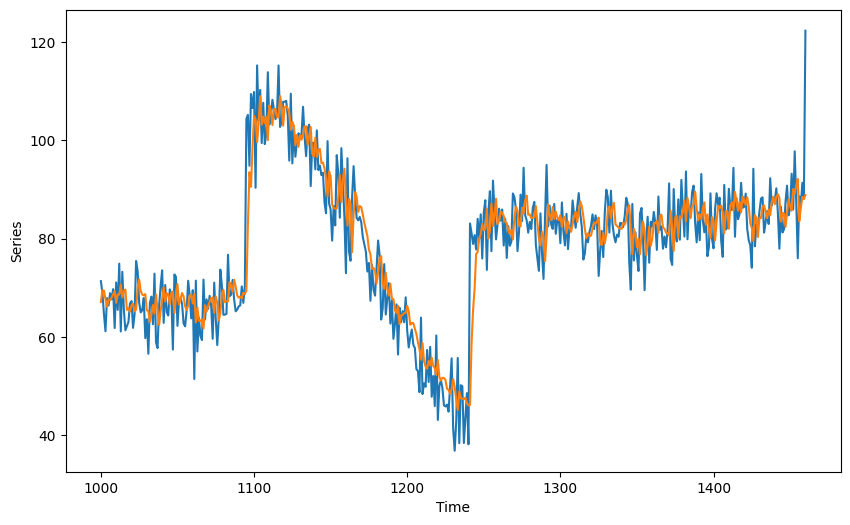

In [114]:
plt.figure(figsize = (10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [115]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.0591736

#### Try SGD optimizer

In [116]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size, batch_size = 128)
valid_set = seq2seq_window_dataset(x_valid, window_size, batch_size = 128)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(100, return_sequences = True,
                          input_shape = [None, 1]),
    keras.layers.SimpleRNN(100, return_sequences = True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0)
])

model.compile(loss = keras.losses.Huber(),
             optimizer = keras.optimizers.SGD(learning_rate = 1e-6, momentum = .9),
             metrics = ['mae'])

early_stopping = keras.callbacks.EarlyStopping(patience = 10)

model.fit(train_set, epochs = 500,
         validation_data = valid_set,
         callbacks = [early_stopping])

Epoch 1/500
8/8 [==============================] - 3s 112ms/step - loss: 54.5527 - mae: 55.0503 - val_loss: 26.2024 - val_mae: 26.6992
Epoch 2/500
8/8 [==============================] - 0s 44ms/step - loss: 37.8312 - mae: 38.3277 - val_loss: 42.5579 - val_mae: 43.0562
Epoch 3/500
8/8 [==============================] - 0s 44ms/step - loss: 28.7188 - mae: 29.2137 - val_loss: 39.0535 - val_mae: 39.5518
Epoch 4/500
8/8 [==============================] - 0s 43ms/step - loss: 24.6189 - mae: 25.1109 - val_loss: 23.3041 - val_mae: 23.7984
Epoch 5/500
8/8 [==============================] - 0s 43ms/step - loss: 21.1101 - mae: 21.6006 - val_loss: 21.3579 - val_mae: 21.8522
Epoch 6/500
8/8 [==============================] - 0s 43ms/step - loss: 18.9127 - mae: 19.4022 - val_loss: 19.5510 - val_mae: 20.0439
Epoch 7/500
8/8 [==============================] - 0s 42ms/step - loss: 17.2552 - mae: 17.7434 - val_loss: 17.1190 - val_mae: 17.6114
Epoch 8/500
8/8 [==============================] - 0s 49ms/st

8/8 [==============================] - 0s 42ms/step - loss: 5.3048 - mae: 5.7811 - val_loss: 5.2144 - val_mae: 5.6922
Epoch 126/500
8/8 [==============================] - 0s 42ms/step - loss: 5.2883 - mae: 5.7646 - val_loss: 5.3178 - val_mae: 5.7962
Epoch 127/500
8/8 [==============================] - 0s 37ms/step - loss: 5.2837 - mae: 5.7599 - val_loss: 5.2293 - val_mae: 5.7058
Epoch 128/500
8/8 [==============================] - 0s 42ms/step - loss: 5.2748 - mae: 5.7508 - val_loss: 5.2083 - val_mae: 5.6852
Epoch 129/500
8/8 [==============================] - 0s 40ms/step - loss: 5.2686 - mae: 5.7447 - val_loss: 5.4118 - val_mae: 5.8945
Epoch 130/500
8/8 [==============================] - 0s 45ms/step - loss: 5.2645 - mae: 5.7402 - val_loss: 5.1937 - val_mae: 5.6713
Epoch 131/500
8/8 [==============================] - 0s 42ms/step - loss: 5.2582 - mae: 5.7342 - val_loss: 5.2135 - val_mae: 5.6899
Epoch 132/500
8/8 [==============================] - 0s 40ms/step - loss: 5.2529 - mae: 5.

In [118]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
# print(rnn_forecast[-1, 0])
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

45/45 [==============================] - 1s 10ms/step


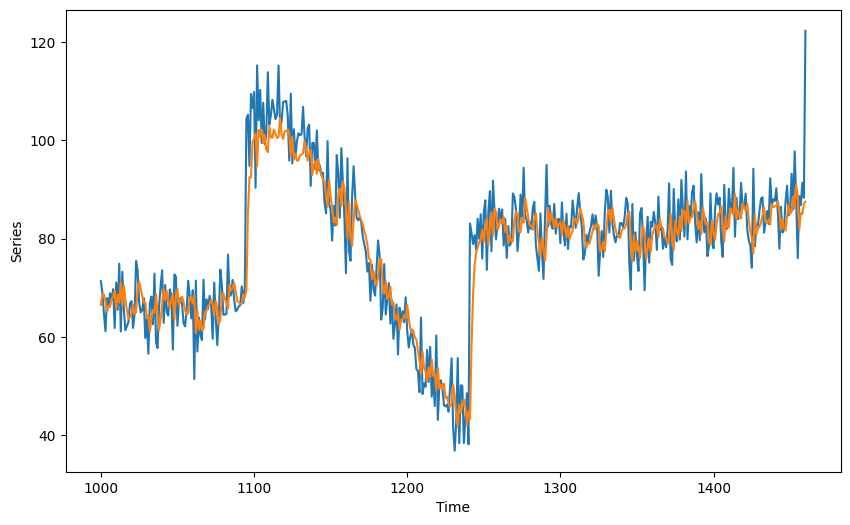

In [119]:
plt.figure(figsize = (10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [120]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

4.99409